In [1]:
import skimage
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_image(img_path):
    """Read in image."""
    img = skimage.io.imread(img_path)
    img = img[:, :, :3]
    return img


def crop_orig(img):
    """Crop color image so pegs are out of frame."""
    cropped = img[800:-150, 400:628, :]
    return cropped


def to_gray(img):
    """Convert to grayscale."""
    bw_img = skimage.color.rgb2gray(img)
    return bw_img


def mask_and_skeletonize(cropped_img, threshold=0.5):
    """Mask the non snake parts of the image and return the outline."""
    mask = (cropped_img < threshold).astype("uint8")
    skeleton = mask * cropped_img
    return skeleton


def process_and_get_skeleton(img_path):
    """Take in path to image and return skeleton of snake."""
    img = load_image(img_path)
    cropped = crop_orig(img)
    bw = to_gray(cropped)
    skeleton = mask_and_skeletonize(bw)
    return skeleton


def get_skeleton_pixels(skeleton):
    """
    Get pixels describing the shape of the skeleton.

    Parameters
    ----------
    skeleton : np.ndarray
        Cropped 2D image of the snake skeleton.

    Returns
    -------
    skelton_pixels : np.ndarray
        2D array containing values where skeleton pixels are located.
    """
    skeleton_pixels = np.argwhere(skeleton)
    return skeleton_pixels


def get_xy_pixel_coords(pixel_coords):
    """
    Get x and y pixel values separately and create list of coordinates.

    Parameters
    ----------
    pixel_coords : np.ndarray
        Array with pixel coordinates.

    Returns
    -------
    coord_tuples : list
        List of tuples with pixel coordinates.
    """
    x = pixel_coords[:, 1]
    y = pixel_coords[:, 0]
    coord_tuples = list(zip(x, y))
    return coord_tuples


def get_unique_coord_vals(coords):
    """Get the unique x and y coordinates from the coordinate tuples."""
    unique_x = list(set([tup[0] for tup in coords]))
    unique_y = list(set([tup[1] for tup in coords]))
    return np.array(unique_x), np.array(unique_y)


def average_x_for_given_y(y_val, tup_list):
    """Average x pixel value for a given y pixel value."""
    all_x_for_y = [tup[0] for tup in tup_list if tup[1] == y_val]
    length = len(all_x_for_y)
    summed = sum(all_x_for_y)
    avg = summed / length
    return avg


def get_all_avg_x(unique_y, coord_tuples):
    """
    Find the average x pixel for each value of y pixel.

    Do it this way because snake curves and looking at unique x doesn't
    mean we are looking at a specific spot on the snake.
    """
    average_x = []
    for y in unique_y:
        avg_x = average_x_for_given_y(y, coord_tuples)
        average_x.append(avg_x)
    average_x = np.array(average_x)
    return average_x


def get_img_plt_center(img_path, save_path="back_overlay.png"):
    """
    Process an image and plot the extracted center line.

    Parameters
    ----------
    img_path : str
        Path to image.

    Returns
    -------
    None
    """
    img = load_image(img_path)
    img = crop_orig(img)
    skeleton = process_and_get_skeleton(img_path)
    skel_pixels = get_skeleton_pixels(skeleton)
    xy_coords = get_xy_pixel_coords(skel_pixels)
    uni_x, uni_y = get_unique_coord_vals(xy_coords)
    average_x = get_all_avg_x(uni_y, coord_tuples=xy_coords)
    plt.figure(figsize=(10, 10))
    skimage.io.imshow(img)
    plt.plot(average_x, uni_y, linewidth=8)
    plt.savefig(save_path)
    plt.show()
    return uni_y, average_x

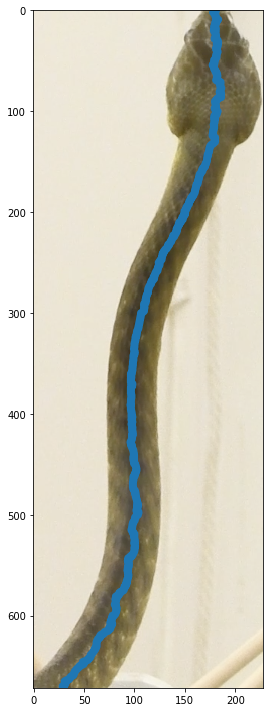

In [3]:
skeleton = process_and_get_skeleton("back_view.png")
skeleton_pixels = get_skeleton_pixels(skeleton)
xy_coords = get_xy_pixel_coords(skeleton_pixels)
uni_x, uni_y = get_unique_coord_vals(xy_coords)
average_x = get_all_avg_x(uni_y, xy_coords)
unique_y, average_x = get_img_plt_center("back_view.png")

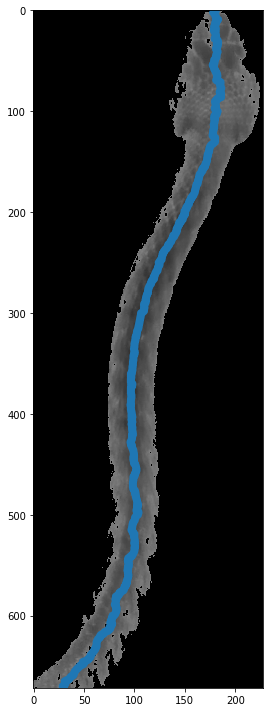

In [4]:
plt.figure(figsize=(10, 10))
plt.plot(average_x, unique_y, linewidth=8)
skimage.io.imshow(skeleton)
plt.show()

In [5]:
from scipy.interpolate import interp1d

In [6]:
points = np.array([list(average_x), list(uni_y)]).T

In [7]:
points.shape

(672, 2)

In [53]:
distance = np.cumsum(np.sqrt(np.sum(np.diff(points, axis=0) ** 2, axis=1)))
distance = np.insert(distance, 0, 0) / distance[-1]

In [68]:
# Interpolation for different methods:
interpolations_methods = ["slinear", "quadratic", "cubic"]
alpha = np.linspace(0, 1, 15)

In [69]:
interpolated_points = {}
for method in interpolations_methods:
    interpolator = interp1d(distance, points, kind=method, axis=0)
    interpolated_points[method] = interpolator(alpha)

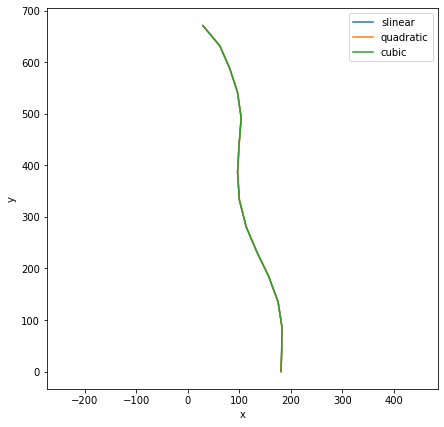

In [70]:
plt.figure(figsize=(7, 7))
for method_name, curve in interpolated_points.items():
    plt.plot(*curve.T, "-", label=method_name)
# plt.plot(*points.T, 'ok', label='original points', linewidth=3);
plt.axis("equal")
plt.legend()
plt.xlabel("x")
plt.ylabel("y");

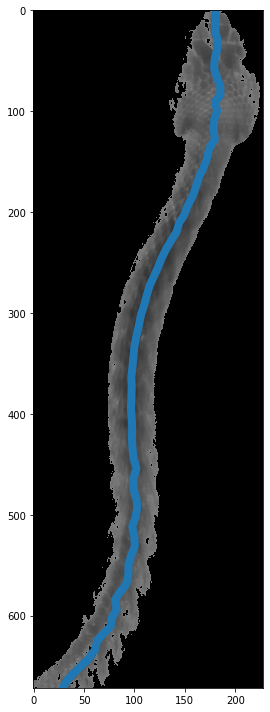

In [44]:
plt.figure(figsize=(10, 10))
plt.plot(
    interpolated_points["slinear"][:, 0],
    interpolated_points["slinear"][:, 1],
    linewidth=8,
)
skimage.io.imshow(skeleton)
plt.show()